<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Linear-Regression-problem" data-toc-modified-id="Linear-Regression-problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Linear Regression problem</a></span></li><li><span><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gradient Descent</a></span></li><li><span><a href="#Gradient-Descent---Classification" data-toc-modified-id="Gradient-Descent---Classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gradient Descent - Classification</a></span></li><li><span><a href="#Gradient-descent-with-numpy" data-toc-modified-id="Gradient-descent-with-numpy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Gradient descent with numpy</a></span></li></ul></div>

In [1]:
%matplotlib inline
from fastai.learner import *

**TODO: Convert this notebook to Pytorch 0.4**


Review and explain Stochastic Gradient Descent (SGD), an **optimization** method commonly used in ANNs. 
We illustrate the concepts with concrete examples.

- `Regression` — the target output is a real number or a whole vector of real numbers
- `Classification` — the target output is a class label

#  Linear Regression problem

The goal of linear regression is to fit a line to a set of points.
As simple as possible.

In [2]:
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, y

x, y = gen_fake_data(50, 3., 8.)

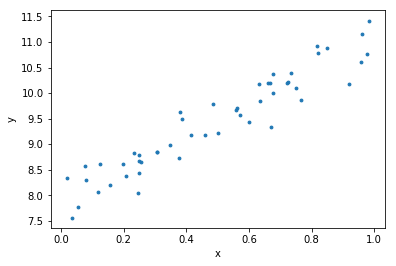

In [3]:
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y"); 

We want to find **parameters** (weights) $a$ and $b$,  
to minimize the *error* between the points and the line $a\cdot x + b$. 
Note that $a$ and $b$ are unknown. <br>
For this we need a *loss function*. 
For regression, the most common *loss function* is **Mean Squared Error (MSE)**. 
Below is a simple implementation of MSE.

In [4]:
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()

Suppose we believe $a = 10$ and $b = 5$.
Then we can compute `y_hat` which is our *prediction* and then compute our error.

In [5]:
y_hat = lin(10,5,x)
mse(y_hat, y)

4.0029985059372759

In [7]:
def mse_loss(a, b, x, y): return mse(lin(a,b,x), y)   # our loss function

In [8]:
mse_loss(10, 5, x, y)

4.0029985059372759

So far we have specified the *model* (linear regression) and the *evaluation criteria* (or *loss function*). Now we need to handle *optimization*; that is, how do we find the best values for $a$ and $b$? How do we find the best *fitting* linear regression.

# Gradient Descent

For a fixed dataset $x$ and $y$ `mse_loss(a,b)` is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [10]:
# generate some more data, 10K points
x, y = gen_fake_data(10000, 3., 8.)
x.shape, y.shape

((10000,), (10000,))

In [11]:
x,y = V(x),V(y)   #make them pytorch Variables so we get the derivatives.

In [12]:
# Create random weights a and b, and wrap them in Variables.
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)
a,b

(Variable containing:
 -1.7212
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 -0.8693
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

Now set the learning rate, and lets do the (10000 epoch) Full Gradient Descent.
(not SGD as each epoch will look at all of the data):
- calculate the loss (a and b are set to random initially)
- (every 1000 epochs), print out the loss
- loss.backward() will calculate gradients for all variables with requires_grad=True and fill in .grad property
update a to whatever it was minus LR * grad ( .data accesses a tensor inside of a variable)
- when there are multiple loss functions or many output layers contributing to the gradient, PyTorch will add them together. So you need to tell when to set gradients back to zero (zero_() in the _ means that the variable is changed in-place).
- The last 4 lines of code is what is wrapped in optim.SGD.step function

In [13]:
learning_rate = 1e-3
for t in range(10000):   
    # Forward pass: compute predicted y using operations on Variables
    loss = mse_loss(a,b,x,y)   # loss is also a Variable, so we can later invoke .backward
    if t % 1000 == 0: print(loss.data[0])  # from time to time
    
    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors inside the variable,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    
    # Extra step in pytorch: Zero the gradients.   
    #The _ at the end every function to a tensor in pytorch does it in place.
    a.grad.data.zero_()
    b.grad.data.zero_()    

127.47213745117188
0.9053255915641785
0.09512176364660263
0.08992057293653488
0.0898762121796608
0.08986758440732956
0.08986146748065948
0.08985679596662521
0.08985290676355362
0.0898497998714447


Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent** (GD). In GD you have to run through *all* the samples in your training set to do a single itaration. In SGD you use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a **batch** or **minibatch**.

# Gradient Descent - Classification

For a fixed dataset $x$ and $y$ `mse_loss(a,b)` is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [38]:
def gen_fake_data2(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, np.where(y>10, 1, 0).astype(np.float32)

In [44]:
x,y = gen_fake_data2(10000, 3., 8.)
x,y = V(x),V(y)

In [64]:
def nll(y_hat, y):
    y_hat = torch.clamp(y_hat, 1e-5, 1-1e-5)
    return (y*y_hat.log() + (1-y)*(1-y_hat).log()).mean()

In [65]:
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)

In [67]:
learning_rate = 1e-2
for t in range(3000):
    p = (-lin(a,b,x)).exp()
    y_hat = 1/(1+p)
    loss = nll(y_hat,y)
    if t % 1000 == 0:
        print(loss.data[0], np.mean(to_np(y)==(to_np(y_hat)>0.5)))
#         print(y_hat)
    
    loss.backward()
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    a.grad.data.zero_()
    b.grad.data.zero_()    

RuntimeError: bool value of Variable objects containing non-empty torch.ByteTensor is ambiguous

Nearly all DL is powered by **Stochastic Gradient Descent (SGD)**, an approximation of **Gradient Descent** (GD).<br>
- In GD we run through *all* the samples in the training set to do a single itaration. 
- In SGD we use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset used in every iteration is called a **batch** or **minibatch**.

# Gradient descent with numpy
Now lets do it without Pytorch, so we do need to do the calculus...

In [14]:
from matplotlib import rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3

In [15]:
x, y = gen_fake_data(50, 3., 8.)

In [16]:
a_guess,b_guess = -1., 1.
mse_loss(a_guess, b_guess, x, y)

85.406482968176974

Create an update without pytorch.
The prediction is linear `lin()`
and now we need to compute the derivatives, dydb and dyda

In [17]:
lr=0.01
def upd():
    global a_guess, b_guess
    y_pred = lin(a_guess, b_guess, x)
    dydb = 2 * (y_pred - y)
    dyda = x*dydb
    a_guess -= lr*dyda.mean()
    b_guess -= lr*dydb.mean()

Lets create an animation that shows how it works...

In [18]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y)
line, = plt.plot(x,lin(a_guess,b_guess,x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess,b_guess,x))
    for i in range(30): upd()
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 20), interval=100)
ani